In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm
import time

class MCMCDDenoiser:
    """
    Markov-chain Monte Carlo Denoising (MCMCD) implementation
    Based on Wong et al. (2011) paper
    """
    
    def __init__(self, image, sigma_s=21, region_radius=3, num_iterations=200):
        """
        Initialize MCMCD denoiser
        
        Parameters:
        -----------
        sigma_s : float
            Standard deviation of random walk (default: 21)
        region_radius : int
            Radius of local patch (default: 3)
        num_iterations : int
            Number of MCMC iterations (default: 200)
        """
        self.sigma_s = sigma_s
        self.region_radius = region_radius
        self.num_iterations = num_iterations
        self.padded_image = np.pad(image, self.region_radius, mode='reflect')
        print(self.padded_image[2][2])
        
    def get_local_region_circ(self, s):
        """Extract local circular region around site s"""
        y, x = s
        y += self.region_radius
        x += self.region_radius

        radius = self.region_radius        
        # Create circular mask
        y_coords, x_coords = np.ogrid[-radius:radius+1, -radius:radius+1]
        mask = x_coords**2 + y_coords**2 <= radius**2
        
        # Extract region with boundary handling
        y_min = y - radius
        y_max = y + radius + 1
        x_min = x - radius
        x_max = x + radius + 1
        
        region = self.padded_image[y_min:y_max, x_min:x_max]
        
        return region * mask
    
    def get_local_region_square(self, s):
        y, x = s
        y += self.region_radius
        x += self.region_radius

        
        # Extract region with boundary handling
        y_min = y - self.region_radius
        y_max = y + self.region_radius + 1
        x_min = x - self.region_radius
        x_max = x + self.region_radius + 1
        
        region = self.padded_image[y_min:y_max, x_min:x_max]
        
        return region
    
    def compute_objective(self, s0, sk, sigma_n_sq, sigma_l_sq):
        """
        Compute Geman-McClure objective function (Eq. 9)
        
        Parameters:
        -----------
        F : ndarray
            Noisy image
        s0 : tuple
            Reference site (y, x)
        sk : tuple
            Candidate site (y, x)
        sigma_n : float
            Noise variance
        sigma_l : float
            Local variance
        """
        # Get local regions
        region_s0 = self.get_local_region_circ(s0)
        region_sk = self.get_local_region_circ(sk)
        
        # Compute Geman-McClure error statistics
        diff = region_sk - region_s0
        diff_sq = diff ** 2
        
        # Avoid division by zero
        denominator = ((sigma_n_sq**2)/(sigma_l_sq)) + diff_sq
        denominator = np.maximum(denominator, 1e-10)
        
        exponent = -np.sum(diff_sq / denominator)
        
        return np.exp(exponent)
    
    def estimate_noise_variance(self, image):
        """Estimate noise variance using median absolute deviation"""
        # Use high-frequency component estimation
        # diff_h = np.diff(image, axis=0)
        # diff_v = np.diff(image, axis=1)
        # sigma = np.median(np.abs(np.concatenate([diff_h.flatten(), diff_v.flatten()]))) / 0.6745
        # sigma = sigma / np.sqrt(2)  # Adjust for differencing
        # return sigma ** 2
        return np.var(image)
    
    def estimate_local_variance(self, s):
        """Estimate local variance around site s"""
        region = self.get_local_region_square(s)
        return self.estimate_noise_variance(region)
    
    def denoise(self, noisy_image = None, verbose=False):
        """
        Denoise image using MCMCD
        
        Parameters:
        -----------
        noisy_image : ndarray
            Noisy input image
        sigma_n : float, optional
            Known noise standard deviation (if None, will be estimated)
        verbose : bool
            Print progress information
        
        Returns:
        --------
        denoised_image : ndarray
            Denoised image
        """
        if(noisy_image is None):
            size = self.padded_image.shape[0] - 2 * self.region_radius
            F = self.padded_image[self.region_radius:self.region_radius+size,
                                            self.region_radius:self.region_radius+size]
        else:
            F = noisy_image.copy()
        h, w = F.shape
        
        # Estimate noise variance if not provided
        sigma_n_sq = self.estimate_noise_variance(F)
        
        if verbose:
            print(f"Image size: {h}x{w}")
            print(f"Noise var: {sigma_n_sq:.2f}")
            print(f"MCMC iterations per pixel: {self.num_iterations}")
            print(f"Processing pixels...")
        
        denoised = np.zeros_like(F)
        
        # Process each pixel with progress bar
        total_pixels = h * w
        pixel_iterator = tqdm(np.ndindex(h, w), 
                             total=total_pixels,
                             desc="Denoising",
                             unit="pixels",
                             disable=not verbose,
                             ncols=80)
        
        for (i, j) in pixel_iterator:
            s0 = (i, j)
            sigma_l_sq = self.estimate_local_variance(s0)
            
            # MCMC sampling
            probabilities = np.zeros(256)
            s_prev = s0
            
            for k in range(self.num_iterations):
                # Draw candidate sample from instrumental distribution (Gaussian)
                dy = np.random.normal(0, self.sigma_s)
                dx = np.random.normal(0, self.sigma_s)
                
                sk_y = int(np.clip(s_prev[0] + dy, 0, h - 1))
                sk_x = int(np.clip(s_prev[1] + dx, 0, w - 1))
                sk = (sk_y, sk_x)
                
                # Compute acceptance probability
                f_sk = self.compute_objective(s0, sk, sigma_n_sq, sigma_l_sq)
                f_prev = self.compute_objective(s0, s_prev, sigma_n_sq, sigma_l_sq)
                
                # Avoid division by zero
                if f_prev > 0:
                    acceptance_prob = min(1.0, f_sk / f_prev)
                else:
                    acceptance_prob = 1.0
                
                # Accept or reject
                u = np.random.uniform(0, 1)
                if u <= acceptance_prob:
                    probabilities[int(F[sk])] += f_sk * np.exp((-np.abs(F[sk] - F[s0]))/255)
                    # samples.append(sk)
                    # weights.append(f_sk)
                    s_prev = sk
            
            # # Estimate posterior and compute conditional mean
            # if len(samples) > 0 and np.sum(weights) > 0:
            #     # Importance-weighted posterior estimation
            #     intensities = [F[s] for s in samples]
            #     weights = np.array(weights)
            #     weights = weights / np.sum(weights)  # Normalize
                
            #     # Conditional mean

            #     denoised[i, j] = np.sum(intensities * weights)
            # else:
            #     # Fallback to original value if no samples
            #     denoised[i, j] = F[i, j]

            Z = np.sum(probabilities)
            if Z != 0:
                probabilities /= Z
                bins = np.linspace(0, 255, 256)
                denoised[i, j] = np.clip(int(np.sum((probabilities * bins))), 0, 255)
            else:
                denoised[i, j] = F[i, j]
        
        if verbose:
            print("\nDenoising complete!")
        
        return denoised

Running MCMCD Denoising Tests


MCMCD Denoising Test

1. Generating chelsea test image (128x128)...
129.63712395296324
2. Adding Gaussian noise (σ = 10)...
3. Denoising with MCMCD...
144.19068398241717
Image size: 128x128
Noise var: 1051.88
MCMC iterations per pixel: 50
Processing pixels...


Denoising: 100%|██████████████████████| 16384/16384 [05:15<00:00, 51.96pixels/s]




Denoising complete!

Results:
Processing time: 315.32 seconds

Noisy Image:
  PSNR: 28.20 dB
  SSIM: 0.7950

Denoised Image:
  PSNR: 28.65 dB
  SSIM: 0.7987

Improvement:
  ΔPSNR: +0.45 dB
  ΔSSIM: +0.0037
SSIM: 0.7741, PSNR: 28.43 dB


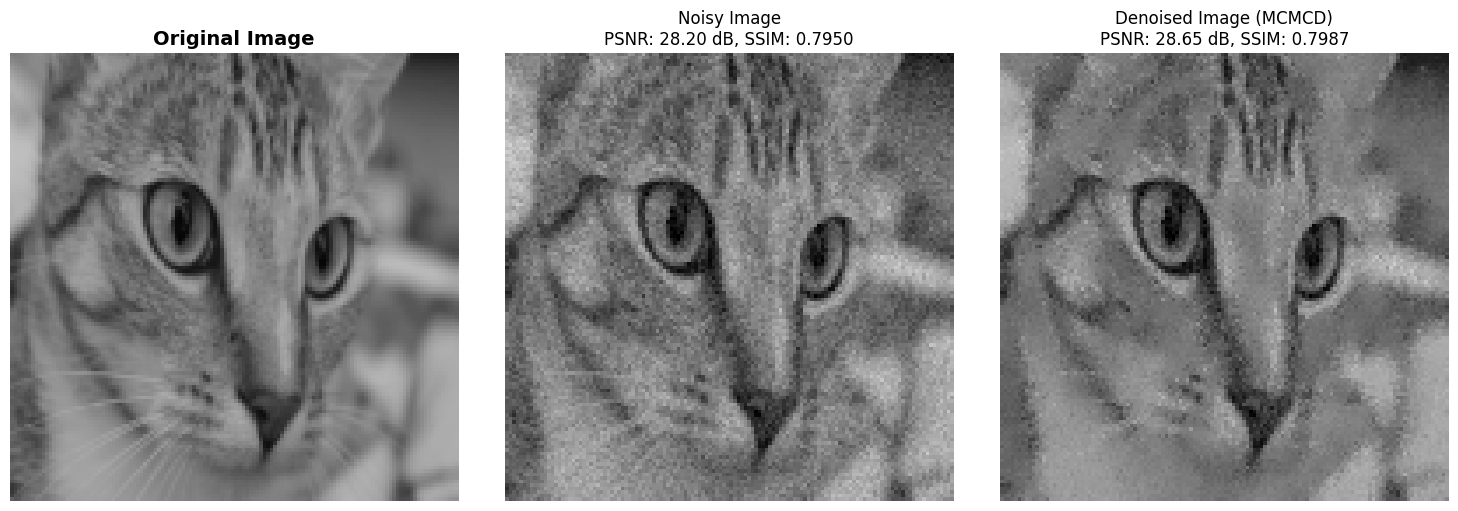

In [ ]:
def generate_test_image(size=128, pattern='camera'):
    """
    Generate test images from scipy.datasets and other sources
    
    Parameters:
    -----------
    size : int
        Image size (will be resized to size x size)
    pattern : str
        Image type: 'camera', 'astronaut', 'coins', 'moon', 'text', 'checkerboard'
    """
    from scipy import datasets, ndimage
    from skimage import transform, color, util, data
    
    if pattern == 'camera':
        # Camera image (512x512 grayscale)
        image = datasets.face(gray=True)
        
    elif pattern == 'astronaut':
        # Astronaut image (needs conversion to grayscale)
        image = data.astronaut()
        
    elif pattern == 'moon':
        image = data.moon()
        
    elif pattern == 'chelsea':
        image = data.chelsea()
        image = color.rgb2gray(image) * 255.0
    elif pattern == 'horse':
        image = data.horse()
        image = util.img_as_float(image) * 255.0
    
    else:
        # Default to ascent image
        image = datasets.ascent()
    
    # Resize to desired size
    if image.shape != (size, size):
        from skimage import transform
        image = transform.resize(image, (size, size), anti_aliasing=True, preserve_range=True)
    
    return np.clip(image, 0, 255)


def add_gaussian_noise(image, sigma):
    """Add Gaussian noise to image"""
    noise = np.random.normal(0, sigma, image.shape)
    noisy = image + noise
    return np.clip(noisy, 0, 255)

from skimage.metrics import structural_similarity, peak_signal_noise_ratio

def image_similarity(img1, img2):
    ssim_score, _ = structural_similarity(img1, img2, full=True)
    psnr_score = peak_signal_noise_ratio(img1, img2)
    return ssim_score, psnr_score


def test_denoising(image_size=128, noise_sigma=5, pattern='chelsea'):
    """
    Test MCMCD denoising on test image
    
    Parameters:
    -----------
    image_size : int
        Size of test image
    noise_sigma : float
        Standard deviation of Gaussian noise
    pattern : str
        Image type: 'camera', 'astronaut', 'coins', 'moon', 'text', 'checkerboard'
    """
    print(f"\n{'='*60}")
    print(f"MCMCD Denoising Test")
    print(f"{'='*60}")
    
    # Generate original image
    print(f"\n1. Generating {pattern} test image ({image_size}x{image_size})...")
    original = generate_test_image(image_size, pattern)
    print(original[2][2])
    
    # Add noise
    print(f"2. Adding Gaussian noise (σ = {noise_sigma})...")
    noisy = add_gaussian_noise(original, noise_sigma)
    
    # Denoise
    print(f"3. Denoising with MCMCD...")
    denoiser = MCMCDDenoiser(noisy, sigma_s=21, region_radius=3, num_iterations=50)
    
    start_time = time.time()
    denoised = denoiser.denoise(verbose=True)
    elapsed_time = time.time() - start_time

    noisy = noisy.astype(np.uint8)
    denoised = denoised.astype(np.uint8)
    
    # Calculate metrics
    psnr_noisy = peak_signal_noise_ratio(original, noisy, data_range=255)
    psnr_denoised = peak_signal_noise_ratio(original, denoised, data_range=255)
    
    ssim_noisy = structural_similarity(original, noisy, data_range=255)
    ssim_denoised = structural_similarity(original, denoised, data_range=255)
    
    print(f"\n{'='*60}")
    print(f"Results:")
    print(f"{'='*60}")
    print(f"Processing time: {elapsed_time:.2f} seconds")
    print(f"\nNoisy Image:")
    print(f"  PSNR: {psnr_noisy:.2f} dB")
    print(f"  SSIM: {ssim_noisy:.4f}")
    print(f"\nDenoised Image:")
    print(f"  PSNR: {psnr_denoised:.2f} dB")
    print(f"  SSIM: {ssim_denoised:.4f}")
    print(f"\nImprovement:")
    print(f"  ΔPSNR: +{psnr_denoised - psnr_noisy:.2f} dB")
    print(f"  ΔSSIM: +{ssim_denoised - ssim_noisy:.4f}")
    ssim_comp, psnr_comp = image_similarity(noisy, denoised)
    print(f"SSIM: {ssim_comp:.4f}, PSNR: {psnr_comp:.2f} dB")
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(noisy, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title(f'Noisy Image\nPSNR: {psnr_noisy:.2f} dB, SSIM: {ssim_noisy:.4f}', 
                      fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(denoised, cmap='gray', vmin=0, vmax=255)
    axes[2].set_title(f'Denoised Image (MCMCD)\nPSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.4f}', 
                      fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return original, noisy, denoised


# Example usage
if __name__ == "__main__":
    # Test with different images and noise levels
    print("Running MCMCD Denoising Tests\n")
    
    # Test 1: Camera/Face image with moderate noise
    test_denoising(image_size=128, noise_sigma=10, pattern='chelsea')
    
    # Uncomment to test other images:
    # test_denoising(image_size=128, noise_sigma=25, pattern='astronaut')
    # test_denoising(image_size=128, noise_sigma=20, pattern='coins')
    # test_denoising(image_size=128, noise_sigma=30, pattern='moon')
    # test_denoising(image_size=128, noise_sigma=20, pattern='text')
    # test_denoising(image_size=128, noise_sigma=25, pattern='checkerboard')